In [3]:
import scipy
import scipy.stats
import numpy as np
import random
import pylab
from keras.layers import Dense
from keras.models import Sequential
from collections import defaultdict

MINPRICE = 3000
MAXPRICE = 4600
INITIALPRICE = 3800

# 환경
class Env:
    def __init__(self):
        self.action_space = ['u', 'l', 'c', 'r', 'd'] # 행동 순서대로 -80, -20, 0, +20, +80
        self.n_actions = len(self.action_space)  # 5 actions
        self.marketPrice = INITIALPRICE            # InitialPrice
        self.p_array = np.random.normal(self.marketPrice, 190, 500) #Passenger의 선호 가격 리스트
        self.p_count = len(self.p_array)                                  #승객의 수 초기 500명
        self.d_array = np.random.normal(self.marketPrice, 190, 500) #Driver의 선호 가격 리스트
        self.d_count = len(self.d_array)                                  #운전자 수 초기 500명
        
    #승객이 가격승낙할 확률
    def acceptP(self, offer, preferred):
        num = 0
        for i in preferred:
            x = (-offer + i) /1600 
            # 누적분포 확률이용
            if np.random.rand() <= scipy.stats.norm(0, 1).cdf(x):
                num += 1
        return num
        
    #운전자가 가격승낙할 확률
    def acceptD(self, offer, preferred):
        num = 0
        for i in preferred:
            x = (offer - i) / 1600
            # 누적분포 확률이용
            if np.random.rand() <= scipy.stats.norm(0, 1).cdf(x):
                num += 1
        return num
        
        
    def step(self, action, count):
        
        if   action == 0:   # up : price-=80
            count=0
            self.marketPrice-=80
            
        elif action == 1:   # left : price-=20
            count=0
            self.marketPrice-=20
            
        elif action == 2:   # center : Nothing happen
            count+=1
            
        elif action == 3:   # right : price+=20
            count=0
            self.marketPrice+=20

        elif action == 4:   # down : price+=80
            count=0
            self.marketPrice+=80


        next_state = self.marketPrice
        reward = 0

        #보상 = next_state가격에서의 (match성사수) * (match 성사가격)
        p_ok = self.acceptP(next_state, self.p_array)
        d_ok = self.acceptD(next_state, self.d_array)
        match = min([p_ok, d_ok])
        reward = match * (next_state/1000)
        
        #보상 가격허용치를 넘으면 -100
        if next_state < MINPRICE or next_state > MAXPRICE:
            reward = -100
        
        # 10번 state변화 없으면 done
        done = False
        if count==10:
            done = True
        
        
        return next_state, reward, done
        
            
    def reset(self):
        self.marketPrice = INITIALPRICE
        self.p_array = np.random.normal(self.marketPrice, 190, 500) #Passenger의 선호 가격 리스트
        self.d_array = np.random.normal(self.marketPrice, 190, 500) #Driver의 선호 가격 리스트

        return self.marketPrice
        
# 가격 Agent
class priceActionModel:
    def __init__(self, actions):
        self.load_model = False
        # 행동 = [0, 1, 2, 3, 4] 순서대로 -80, -20, 0, +20, +80
        self.action_space = [0, 1, 2, 3, 4]
        self.action_size = len(self.action_space)
        self.state_size = 15
        self.discount_factor = 0.99
        self.learning_rate = 0.001
        
        self.epsilon = 1.  # exploration
        self.epsilon_decay = .9999
        self.epsilon_min = 0.01
        self.model = self.build_model()
        
        if self.load_model:
            self.epsilon = 0.05
            self.model.load_weights('./save_model/deep_sarsa_DP_trained.h5')
    
    # 상태가 입력 큐함수가 출력인 인공신경망 생성
    def build_model(self):
        model = Sequential()
        model.add(Dense(30, input_dim=self.state_size, activation='relu'))
        model.add(Dense(30, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.summary()
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model
    
    # 모델 훈련
    def train_model(self, state, action, reward, next_state, next_action, done):
        if self.epsilon > self.epsilo_min:
            self.epsilon *= self.epsilon_decay
            
        state = np.float32(state)
        next_state = np.float32(next_state)
        target = self.model.predict(state)[0]
        
        # 살사의 큐함수 업데이트 식
        # 끝났다면 즉각적인 보상만 고려
        if done:
            target[action] = reward
        else:
            target[action] = (reward + self.discount_factor *
                              self.model.predict(next_state)[0][next_action])
            
        # 출력 값 reshape
        target = np.reshape(target, [1, 5])
        # 인공신경망 업데이트
        self.model.fit(state, target, epochs=1, verbose=0)
        
        
    # 입실론 탐욕 정책에 따라서 행동을 선택
    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            #무작위 행동 반환
            return random.randrange(self.action_size)
            
        else:
            # 모델로부터 행동 산출
            state = np.float32(state)
            q_values = self.model.predict(state)
            return np.argmax(q_values[0])
        
    
    
if __name__ == "__main__":
    
    env = Env()
    agent = priceActionModel(actions=list(range(env.n_actions)))            # [0, 1, 2, 3, 4]
    
    global_step = 0
    scores, episodes = [], []
    
    
    for episode in range(20):
        state = env.reset()
        count = 0
        
        for i in range(50000):
            global_step += 1

            # 현재 상태에 대한 행동 선택
            action = agent.get_action(str(state))
            
            # 행동을 취한 후 다음 상태, 보상 에피소드의 종료여부를 받아옴
            next_state, reward, done = env.step(action, count)

            # <s,a,r,s'>로 큐함수를 업데이트
            agent.learn(str(state), action, reward, str(next_state))
            state = next_state
            # 모든 큐함수를 화면에 표시
#           env.print_value_all(agent.q_table)

           
            scores.append(state)
            episodes.append(episode*50000 + i)
            pylab.plot(episodes, scores, 'b')
            pylab.savefig("./DP_graph.png")
            print("episode:", episode, "  score:", state, " global_step:",
                  global_step, "  epsilon : ", agent.epsilon*100, "%")
            

ModuleNotFoundError: No module named 'keras'

In [ ]:
import numpy as np
import scipy
import scipy.stats
marketPrice = 3800
list_a = np.random.normal(marketPrice,190,500)
list_b = np.random.normal(marketPrice,190,500)
#list_a = np.sort(list_a)

c = []
def aa(a,b):
    for i in range(500):
        if a[i] < b[i]:
            c.append(1)
        else:
            c.append(0)
    print(c)

    
def accept(offer, preferred, bias):
    x = (preferred - offer) / bias
    N = (x - preferred) / bias                                        # -1<= N <=1      
    r = np.random.rand()
    c = scipy.stats.norm(0, 1).cdf(N)
    print(x, N, r, c)
    if r <= c:
        return 1
    return 0

print(accept(210, 10, 100))


In [ ]:
import scipy
X = np.random.normal(marketPrice,190,500)
Y = np.random.normal(marketPrice,190,500)

def acceptP(offer, preferred):
    count = 0
    for i in preferred:
        x = (-offer + i) / 1600
        p = scipy.stats.norm(0, 1).cdf(x)
        r = np.random.rand()
#         print(x,r,p)
        if r <= p:
            count += 1
    return count
    
def acceptD(offer, preferred):
    count = 0
    for i in preferred:
        x = (offer - i) / 1600
        p = scipy.stats.norm(0, 1).cdf(x)
        r = np.random.rand()
#         print(x,r,p)
        if r <= p:
            count += 1
    return count

print(acceptP(4600, X))
print(acceptD(4600, Y))


In [ ]:
# 가격 & 운전자 및 승객 상태 리스트 (소수점 반올림)
import math
Matrix = [[3]*500 for i in range(2)]
Matrix[0] = np.random.normal(3800,190,500).tolist()
for i in range(500):
    Matrix[0][i] = math.ceil(Matrix[0][i])
print(Matrix)
print(type(Matrix))

episode: 0   score: 3800  global_step: 1   epsilon: 0.9999
episode: 0   score: 3880  global_step: 2   epsilon: 0.9998000100000001
episode: 0   score: 3860  global_step: 3   epsilon: 0.9997000299990001
episode: 0   score: 3880  global_step: 4   epsilon: 0.9996000599960002
episode: 0   score: 3800  global_step: 5   epsilon: 0.9995000999900007
episode: 0   score: 3800  global_step: 6   epsilon: 0.9994001499800017
episode: 0   score: 3720  global_step: 7   epsilon: 0.9993002099650037
episode: 0   score: 3800  global_step: 8   epsilon: 0.9992002799440072
episode: 0   score: 3800  global_step: 9   epsilon: 0.9991003599160128
episode: 0   score: 3820  global_step: 10   epsilon: 0.9990004498800211
episode: 0   score: 3900  global_step: 11   epsilon: 0.9989005498350332
episode: 0   score: 3880  global_step: 12   epsilon: 0.9988006597800497
episode: 0   score: 3880  global_step: 13   epsilon: 0.9987007797140718
episode: 0   score: 3800  global_step: 14   epsilon: 0.9986009096361004
episode: 0   

KeyboardInterrupt: 

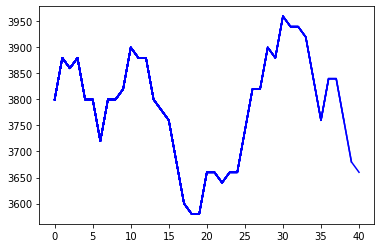

In [5]:
# Q-learning table사용
import scipy
import scipy.stats
import numpy as np
import random
import pylab
from collections import defaultdict


MINPRICE = 3000
MAXPRICE = 4600
INITIALPRICE = 3800


# 환경
class Env:
    def __init__(self):
        self.action_space = ['u', 'l', 'c', 'r', 'd'] # 행동 순서대로 -80, -20, 0, +20, +80
        self.n_actions = len(self.action_space)  # 5 actions
        self.marketPrice = INITIALPRICE            # InitialPrice
        self.p_array = np.random.normal(self.marketPrice, 190, 500) #Passenger의 선호 가격 리스트
        self.p_count = len(self.p_array)                                  #승객의 수 초기 500명
        self.d_array = np.random.normal(self.marketPrice, 190, 500) #Driver의 선호 가격 리스트
        self.d_count = len(self.d_array)                                  #운전자 수 초기 500명
        #만족도옵션 추가
        
    #승객이 가격승낙할 확률
    def acceptP(self, offer, preferred):
        num = 0
        for i in preferred:
            x = (-offer + i) / 1600 
            # 누적분포 확률이용
            if np.random.rand() <= scipy.stats.norm(0, 1).cdf(x):
                num += 1
        return num
        
    #운전자가 가격승낙할 확률
    def acceptD(self, offer, preferred):
        num = 0
        for i in preferred:
            x = (offer - i) / 1600
            # 누적분포 확률이용
            if np.random.rand() <= scipy.stats.norm(0, 1).cdf(x):
                num += 1
        return num
        
        
    def step(self, action, count):
        
        if   action == 0:   # up : price-=80
            count=0
            self.marketPrice-=80
            
        elif action == 1:   # left : price-=20
            count=0
            self.marketPrice-=20
            
        elif action == 2:   # center : Nothing happen
            count+=1
            
        elif action == 3:   # right : price+=20
            count=0
            self.marketPrice+=20

        elif action == 4:   # down : price+=80
            count=0
            self.marketPrice+=80


        next_state = self.marketPrice
        reward = 0

        #보상 = next_state가격에서의 (match성사수) * (match 성사가격)
        p_ok = self.acceptP(next_state, self.p_array)
        d_ok = self.acceptD(next_state, self.d_array)
        match = min([p_ok, d_ok])
        reward = match * (next_state/1000)
        
        #보상 가격허용치를 넘으면 -100
        if next_state < MINPRICE or next_state > MAXPRICE:
            reward = -100
        
        # 10번 state변화 없으면 done
        done = False
        if count==10:
            done = True
        
        
        return next_state, reward, done
        
            
    def reset(self):
        self.marketPrice = INITIALPRICE
        self.p_array = np.random.normal(self.marketPrice, 190, 500) #Passenger의 선호 가격 리스트
        self.d_array = np.random.normal(self.marketPrice, 190, 500) #Driver의 선호 가격 리스트

        return self.marketPrice
        
# 가격 Agent
class priceActionModel:
    def __init__(self, actions):
        # 행동 = [0, 1, 2, 3, 4] 순서대로 -80, -20, 0, +20, +80
        self.actions = actions
        self.learning_rate = 0.01
        self.discount_factor = 0.9
        self.epsilon = 1.  # exploration
        self.epsilon_decay = .9999
        self.epsilon_min = 0.01
        self.q_table = defaultdict(lambda: [0.0, 0.0, 0.0, 0.0, 0.0]) # 5열
        
    # <s, a, r, s'> 샘플로부터 큐함수 업데이트
    def learn(self, state, action, reward, next_state):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
        q_1 = self.q_table[state][action]
        # 벨만 최적 방정식을 사용한 큐함수의 업데이트
        q_2 = reward + self.discount_factor * max(self.q_table[next_state])
        self.q_table[state][action] += self.learning_rate * (q_2 - q_1)
    
    # 큐함수에 의거하여 입실론 탐욕 정책에 따라서 행동을 반환
    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            # 10% 확률로 무작위 행동 반환
            action = np.random.choice(self.actions)
        else:
            # 큐함수에 따른 행동 반환
            print(state, self.q_table[state])
            state_action = self.q_table[state]
            action = self.arg_max(state_action)
        return action
        
    @staticmethod
    def arg_max(state_action):
        max_index_list = []
        max_value = state_action[0]
        for index, value in enumerate(state_action):
            if value > max_value:
                max_index_list.clear()
                max_value = value
                max_index_list.append(index)
            elif value == max_value:
                max_index_list.append(index)
        return random.choice(max_index_list)
    
if __name__ == "__main__":
    
    env = Env()
    agent = priceActionModel(actions=list(range(env.n_actions)))            # [0, 1, 2, 3, 4]
    
    global_step = 0
    scores, episodes = [], []
    
    
    for episode in range(20):
        state = env.reset()
        count = 0
        
        for i in range(50000):
            global_step += 1

            # 현재 상태에 대한 행동 선택
            action = agent.get_action(str(state))
            
            # 행동을 취한 후 다음 상태, 보상 에피소드의 종료여부를 받아옴
            next_state, reward, done = env.step(action, count)

            # <s,a,r,s'>로 큐함수를 업데이트
            agent.learn(str(state), action, reward, str(next_state))
            state = next_state
            # 모든 큐함수를 화면에 표시
            #env.print_value_all(agent.q_table)

            scores.append(state)
            episodes.append(episode*50000 + i)
            pylab.plot(episodes, scores, 'b')
            pylab.savefig("./DP_graph0.png")
            print("episode:", episode, "  score:", state, " global_step:",
                  global_step, "  epsilon:", agent.epsilon)
            

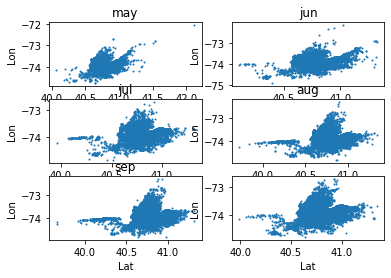

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

data4 = pd.read_csv("./Data/location/uber-raw-data-apr14.csv")
data5 = pd.read_csv("./Data/location/uber-raw-data-may14.csv")
data6 = pd.read_csv("./Data/location/uber-raw-data-jun14.csv")
data7 = pd.read_csv("./Data/location/uber-raw-data-jul14.csv")
data8 = pd.read_csv("./Data/location/uber-raw-data-aug14.csv")
data9 = pd.read_csv("./Data/location/uber-raw-data-sep14.csv")

plt.title("apr")
plt.subplot(321)
plt.scatter(data4.Lat , data4.Lon, s= 1)
plt.xlabel("Lat")
plt.ylabel("Lon")

plt.title("may")
plt.subplot(322)
plt.scatter(data5.Lat , data5.Lon, s= 1)
plt.xlabel("Lat")
plt.ylabel("Lon")

plt.title("jun")
plt.subplot(323)
plt.scatter(data6.Lat , data6.Lon, s= 1)
plt.xlabel("Lat")
plt.ylabel("Lon")

plt.title("jul")
plt.subplot(324)
plt.scatter(data7.Lat , data7.Lon, s= 1)
plt.xlabel("Lat")
plt.ylabel("Lon")

plt.title("aug")
plt.subplot(325)
plt.scatter(data8.Lat , data8.Lon, s= 1)
plt.xlabel("Lat")
plt.ylabel("Lon")

plt.title("sep")
plt.subplot(326)
plt.scatter(data9.Lat , data9.Lon, s= 1)
plt.xlabel("Lat")
plt.ylabel("Lon")

plt.show()


In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib import cm
%matplotlib inline

ModuleNotFoundError: No module named 'mpl_toolkits.basemap'

In [ ]:
DATA_FILE = '../input/uber-raw-data-aug14.csv'
uber_data = pd.read_csv(DATA_FILE)
uber_data.head()

In [ ]:
uber_data.info()

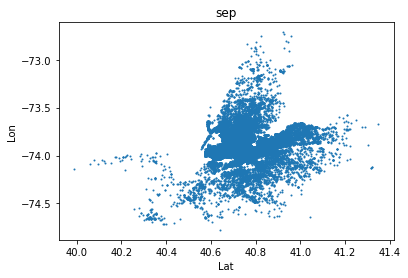

In [33]:
plt.title("sep")
plt.scatter(data9.Lat , data9.Lon, s= 1)
plt.xlabel("Lat")
plt.ylabel("Lon")

plt.show()

In [82]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler

data9 = pd.read_csv("./Data/location/uber-raw-data-sep14.csv")
print("Shape of the DataFrame: ", data9.shape)

data = data9[["Lat","Lon"]]
data = data.to_numpy()


STdata = StandardScaler().fit(data)
x_STdata = STdata.transform()
db = DBSCAN(eps=0.3, min_samples=5 , metric='euclidean').fit(STdata)
db.labels_



# _db = db.fit_predict(X)
# plt.scatter(db.Lat , db.Lon, s= 1)
# plt.show()

Shape of the DataFrame:  (1028136, 4)


MemoryError: 

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt


data9 = pd.read_csv("./Data/location/uber-raw-data-sep14.csv")
print("Shape of the DataFrame: ", data9.shape)

data = data9[["Lat","Lon"]].head(10000)
x = data.to_numpy()

scaler_ss = StandardScaler().fit(x)
x_scaled_ss = scaler_ss.transform(x) 
dbscan = DBSCAN()
clusters_ss = dbscan.fit_predict(x_scaled_ss)
print('np.unique(clusters_ss)\n예측한 레이블:{}'.format(np.unique(clusters_ss))) # [0 ,1]

df = np.hstack([x_scaled_ss, clusters_ss.reshape(-1, 1)]) # x_scaled_ss 오른쪽에 1열 붙이기

df_ftm1 = df[df[:,2]==-1, :] # 클러스터 -1 추출
df_ft0 = df[df[:,2]==0, :] # 클러스터 0 추출
df_ft1 = df[df[:,2]==1, :] # 클러스터 1 추출
df_ft2 = df[df[:,2]==2, :] # 클러스터 2 추출

# matplotlib로 그래프 그리기
plt.scatter(df_ftm1[:, 0], df_ftm1[:, 1], label='cluster -1', cmap='Pairs') # x, y, label, 색상
plt.scatter(df_ft0[:, 0], df_ft0[:, 1], label='cluster 0', cmap='Pairs')
plt.scatter(df_ft1[:, 0], df_ft1[:, 1], label='cluster 1', cmap='Pairs') # x, y, label, 색상
plt.scatter(df_ft2[:, 0], df_ft2[:, 1], label='cluster 2', cmap='Pairs')
plt.xlabel('feature 0')
plt.ylabel('feature 1')
plt.legend()
plt.show()

In [ ]:
def plotResult(X, y, title='클러스터링 결과'):
    plt.scatter(X[y==0, 0], X[y==0, 1], c = 'lightblue' , marker='o', s=40, label='클러스터1')
    plt.scatter(X[y==1, 0], X[y==1, 1], c = 'red' , marker='s', s=40, label='클러스터2')
    plt.title(title)
    plt.legend()
    plt.show()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import pickle as pkl

with open('./DBs.pkl', 'rb')as f:
    df = pkl.load(f)

In [ ]:
df_ftm1 = df[df[:,2]==-1, :] # 클러스터 -1 추출
df_ft0 = df[df[:,2]==0, :] # 클러스터 0 추출
df_ft1 = df[df[:,2]==1, :] # 클러스터 1 추출
df_ft2 = df[df[:,2]==2, :] # 클러스터 2 추출
df_ft3 = df[df[:,2]==3, :] # 클러스터 3 추출
df_ft4 = df[df[:,2]==4, :] # 클러스터 4 추출
df_ft5 = df[df[:,2]==5, :] # 클러스터 5 추출
df_ft6 = df[df[:,2]==6, :] # 클러스터 6 추출
df_ft7 = df[df[:,2]==7, :] # 클러스터 7 추출
df_ft8 = df[df[:,2]==8, :] # 클러스터 8 추출
df_ft9 = df[df[:,2]==9, :] # 클러스터 9 추출
df_ft10 = df[df[:,2]==10, :] # 클러스터 10 추출
df_ft11 = df[df[:,2]==11, :] # 클러스터 11 추출
df_ft12 = df[df[:,2]==12, :] # 클러스터 12 추출
df_ft13 = df[df[:,2]==13, :] # 클러스터 13 추출
df_ft14 = df[df[:,2]==14, :] # 클러스터 14 추출
df_ft15 = df[df[:,2]==15, :] # 클러스터 15 추출
df_ft16 = df[df[:,2]==16, :] # 클러스터 16 추출
df_ft17 = df[df[:,2]==17, :] # 클러스터 17 추출
df_ft18 = df[df[:,2]==18, :] # 클러스터 18 추출
df_ft19 = df[df[:,2]==19, :] # 클러스터 19 추출
df_ft20 = df[df[:,2]==20, :] # 클러스터 20 추출

# matplotlib로 그래프 그리기
# plt.scatter(df_ftm1[:, 0], df_ftm1[:, 1], label='cluster -1', cmap='Pairs', s=1) 
# plt.scatter(df_ft0[:, 0], df_ft0[:, 1], label='cluster 0', cmap='Pairs', s=1)
plt.scatter(df_ft1[:, 0], df_ft1[:, 1], label='cluster 1', cmap='Pairs', s=1)
plt.scatter(df_ft2[:, 0], df_ft2[:, 1], label='cluster 2', cmap='Pairs', s=1)
plt.scatter(df_ft3[:, 0], df_ft3[:, 1], label='cluster 3', cmap='Pairs', s=1)
plt.scatter(df_ft4[:, 0], df_ft4[:, 1], label='cluster 4', cmap='Pairs', s=1)
plt.scatter(df_ft5[:, 0], df_ft5[:, 1], label='cluster 5', cmap='Pairs', s=1)
plt.scatter(df_ft6[:, 0], df_ft6[:, 1], label='cluster 6', cmap='Pairs', s=1)
plt.scatter(df_ft7[:, 0], df_ft7[:, 1], label='cluster 7', cmap='Pairs', s=1)
plt.scatter(df_ft8[:, 0], df_ft8[:, 1], label='cluster 8', cmap='Pairs', s=1)
plt.scatter(df_ft9[:, 0], df_ft9[:, 1], label='cluster 9', cmap='Pairs', s=1)
plt.scatter(df_ft10[:, 0], df_ft10[:, 1], label='cluster 10', cmap='Pairs', s=1)
plt.scatter(df_ft11[:, 0], df_ft11[:, 1], label='cluster 11', cmap='Pairs', s=1)
plt.scatter(df_ft12[:, 0], df_ft12[:, 1], label='cluster 12', cmap='Pairs', s=1)
plt.scatter(df_ft13[:, 0], df_ft13[:, 1], label='cluster 13', cmap='Pairs', s=1)
plt.scatter(df_ft14[:, 0], df_ft14[:, 1], label='cluster 14', cmap='Pairs', s=1)
plt.scatter(df_ft15[:, 0], df_ft15[:, 1], label='cluster 15', cmap='Pairs', s=1)
plt.scatter(df_ft16[:, 0], df_ft16[:, 1], label='cluster 16', cmap='Pairs', s=1)
plt.scatter(df_ft17[:, 0], df_ft17[:, 1], label='cluster 17', cmap='Pairs', s=1)
plt.scatter(df_ft18[:, 0], df_ft18[:, 1], label='cluster 18', cmap='Pairs', s=1)
plt.scatter(df_ft19[:, 0], df_ft19[:, 1], label='cluster 19', cmap='Pairs', s=1)
plt.scatter(df_ft20[:, 0], df_ft20[:, 1], label='cluster 20', cmap='Pairs', s=1)
plt.xlabel('feature 0')
plt.ylabel('feature 1')
plt.legend()
plt.show()

In [ ]:
import pandas as pd

data9 = pd.read_csv("./Data/location/uber-raw-data-sep14.csv")
data9

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.datasets as data
%matplotlib inline
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 50, 'linewidths':0}
plt.rcParams["figure.figsize"] = [9,7]
"""!pip install hdbscan"""
import hdbscan

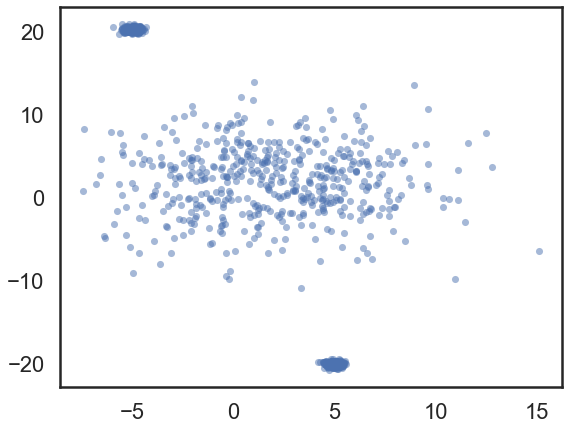

In [49]:
num=500
#moons, _ = data.make_moons(n_samples=num, noise=0.1)
blobs, _ = data.make_blobs(n_samples=num, centers=[(-5,20.25), (5.0, -20.0)], cluster_std=0.25)
blobs2, _ = data.make_blobs(n_samples=num, centers=[(2,2.25)], cluster_std=4)
test_data = np.vstack([ blobs,blobs2])
plt.scatter(test_data.T[0], test_data.T[1], color='b', **plot_kwds)
plt.show()

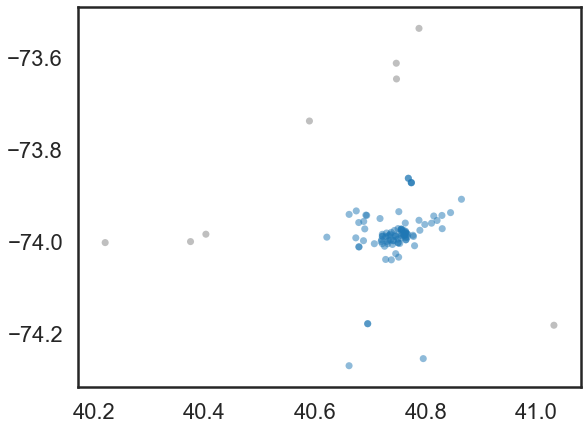

In [8]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.datasets as data
%matplotlib inline
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 50, 'linewidths':0}
plt.rcParams["figure.figsize"] = [9,7]
"""!pip install hdbscan"""
import hdbscan

data9 = pd.read_csv("./Data/location/uber-raw-data-sep14.csv")
data = data9[["Lat","Lon"]].head(100)
test_data = data.to_numpy()
db = DBSCAN(eps=0.2, min_samples=10).fit(test_data)
palette = sns.color_palette()
cluster_colors = [palette[col]
                  if col >= 0 else (0.5, 0.5, 0.5) for col in
                  db.labels_]
plt.scatter(test_data.T[0], test_data.T[1], c=cluster_colors, **plot_kwds)

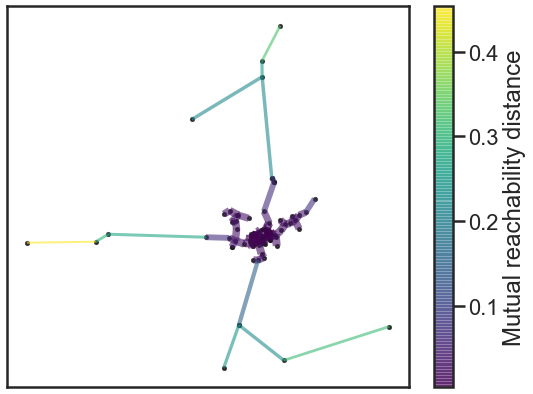

In [10]:
#HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)
clusterer.fit(test_data)

clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis', 
                                      edge_alpha=0.6, 
                                      node_size=10, 
                                      edge_linewidth=2)

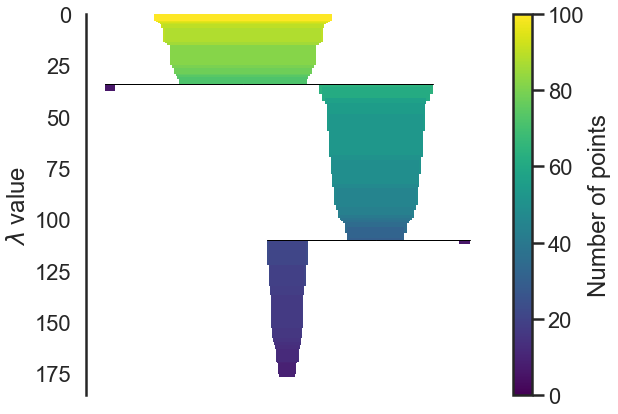

In [11]:
clusterer.condensed_tree_.plot()

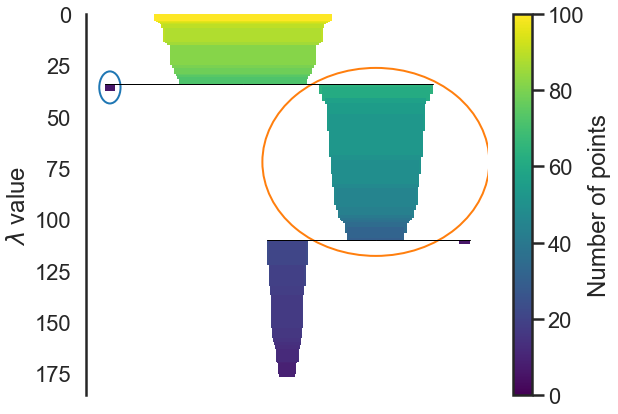

In [12]:
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())


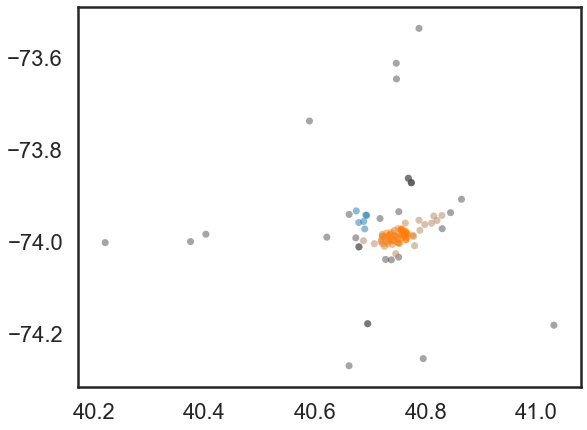

In [13]:
palette = sns.color_palette()
cluster_colors = [sns.desaturate(palette[col], sat)
                  if col >= 0 else (0.3,0.3,0.3) for col, sat in
                  zip(clusterer.labels_, clusterer.probabilities_)]
plt.scatter(test_data.T[0], test_data.T[1], c=cluster_colors, **plot_kwds)

In [70]:
import pandas as pd
data = pd.read_csv("./Data/location/uber-raw-data-sep14.csv")
data['date'] = data['Date/Time'].str.split(' ').str[0]
data['time'] = data['Date/Time'].str.split(' ').str[1]

data['date'] = data['date'].str.split('\/').str[1]
data['time'] = data['time'].str.split(':').str[0]
print(data)

                  Date/Time      Lat      Lon    Base date time
0          9/1/2014 0:01:00  40.2201 -74.0021  B02512    1    0
1          9/1/2014 0:01:00  40.7500 -74.0027  B02512    1    0
2          9/1/2014 0:03:00  40.7559 -73.9864  B02512    1    0
3          9/1/2014 0:06:00  40.7450 -73.9889  B02512    1    0
4          9/1/2014 0:11:00  40.8145 -73.9444  B02512    1    0
...                     ...      ...      ...     ...  ...  ...
1028131  9/30/2014 22:57:00  40.7668 -73.9845  B02764   30   22
1028132  9/30/2014 22:57:00  40.6911 -74.1773  B02764   30   22
1028133  9/30/2014 22:58:00  40.8519 -73.9319  B02764   30   22
1028134  9/30/2014 22:58:00  40.7081 -74.0066  B02764   30   22
1028135  9/30/2014 22:58:00  40.7140 -73.9496  B02764   30   22

[1028136 rows x 6 columns]


In [71]:
clus = []
for i in data['date'].unique() :
    for j in data['time'].unique() :
        clus.append(data[data['time'] == str(j)][data[data['time'] == str(j)]['date'] == str(i)])

In [192]:
len(clus)
for i in clus:
    print(len(i))

699
490
363
333
261
283
330
427
560
765
874
988
1021
1125
1222
1345
1473
1341
1248
1251
1181
1055
818
508
209
111
84
293
518
858
1271
1596
1728
1256
1162
1138
1188
1288
1401
1719
2046
2146
1960
1765
1758
1515
1122
699
284
151
116
204
356
760
1383
1676
1669
1394
1232
1182
1205
1376
1626
2035
2336
2458
2376
2189
2208
1917
1574
924
492
266
180
247
384
760
1368
1753
1801
1455
1384
1399
1422
1552
1874
2346
2493
2735
3087
2808
2617
2446
2074
1417
651
362
233
303
468
827
1333
1707
1859
1609
1485
1432
1445
1713
2057
2323
2655
2961
3151
3157
2738
2793
2763
2294
1706
1122
706
476
348
340
526
710
953
1085
1286
1475
1600
1871
2133
2414
2579
2776
2854
2742
2422
2713
3034
2649
1830
1237
823
566
334
358
387
564
813
1024
1227
1397
1485
1639
1811
1988
2147
2036
1909
1708
1616
1444
1162
629
323
201
157
369
515
910
1222
1673
1725
1288
1204
1211
1190
1345
1577
1895
2092
2254
2221
1971
1823
1487
1117
590
312
194
146
242
407
826
1443
1778
1785
1330
1293
1294
1319
1639
2028
2234
2237
2616
2682
2379
2181
1908

1683
Max label :  13
-1 Label count :  131
0 Label count :  1213
1 Label count :  104
2 Label count :  31
3 Label count :  29
4 Label count :  57
5 Label count :  44
6 Label count :  9
7 Label count :  6
8 Label count :  15
9 Label count :  16
10 Label count :  7
11 Label count :  7
12 Label count :  7
13 Label count :  7


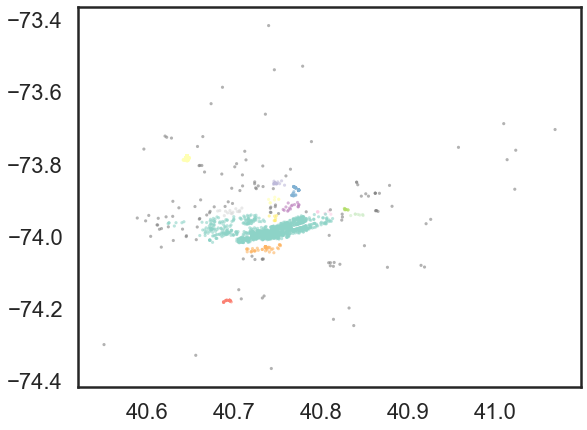

In [320]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.datasets as data
%matplotlib inline
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.6, 's' : 10, 'linewidths':0} 
plt.rcParams["figure.figsize"] = [9,7]
"""!pip install hdbscan"""
import hdbscan

data9 = clus[496]
print(len(data9))
data = data9[["Lat","Lon"]]
test_data = data.to_numpy()

db = DBSCAN(eps=0.01, min_samples=7).fit(test_data)
palette = sns.color_palette("Set3", 14)
cluster_colors = [palette[col]
                  if col >= 0 else (0.5, 0.5, 0.5) for col in
                  db.labels_]
print("Max label : ", db.labels_.max())

for i in np.unique(db.labels_):
    print(i, "Label count : " ,db.labels_[db.labels_ == i].size)
    
plt.scatter(test_data.T[0], test_data.T[1], c=cluster_colors, **plot_kwds)



In [323]:
a = 0 
b = 0
for i in range(len(clus) - 1):
    data9 = clus[i]
    print(len(data9), "  ", i)
    
    data = data9[["Lat","Lon"]]
    test_data = data.to_numpy()

    db = DBSCAN(eps=0.01, min_samples=7).fit(test_data)
#     palette = sns.color_palette("deep", 14)
#     cluster_colors = [palette[col]
#                       if col >= 0 else (0.5, 0.5, 0.5) for col in
#                       db.labels_]
    print("Max label : ", db.labels_.max())
    if db.labels_.max() > a:
        a = db.labels_.max()
        b = i
print(a, b)

699    0
Max label :  4
490    1
Max label :  4
363    2
Max label :  2
333    3
Max label :  4
261    4
Max label :  2
283    5
Max label :  4
330    6
Max label :  5
427    7
Max label :  6
560    8
Max label :  5
765    9
Max label :  10
874    10
Max label :  4
988    11
Max label :  6
1021    12
Max label :  6
1125    13
Max label :  5
1222    14
Max label :  8
1345    15
Max label :  8
1473    16
Max label :  7
1341    17
Max label :  8
1248    18
Max label :  6
1251    19
Max label :  6
1181    20
Max label :  5
1055    21
Max label :  7
818    22
Max label :  7
508    23
Max label :  8
209    24
Max label :  4
111    25
Max label :  2
84    26
Max label :  1
293    27
Max label :  1
518    28
Max label :  8
858    29
Max label :  4
1271    30
Max label :  10
1596    31
Max label :  8
1728    32
Max label :  7
1256    33
Max label :  5
1162    34
Max label :  7
1138    35
Max label :  5
1188    36
Max label :  4
1288    37
Max label :  6
1401    38
Max label :  5
1719    39
Max 

Max label :  4
770    320
Max label :  5
969    321
Max label :  7
1123    322
Max label :  7
1359    323
Max label :  6
1323    324
Max label :  5
1512    325
Max label :  8
1587    326
Max label :  7
1786    327
Max label :  9
1903    328
Max label :  6
1870    329
Max label :  9
1796    330
Max label :  9
1624    331
Max label :  7
1521    332
Max label :  7
1237    333
Max label :  7
1012    334
Max label :  6
505    335
Max label :  8
257    336
Max label :  4
172    337
Max label :  1
158    338
Max label :  1
346    339
Max label :  3
571    340
Max label :  7
883    341
Max label :  6
1357    342
Max label :  7
1694    343
Max label :  7
1706    344
Max label :  6
1249    345
Max label :  7
1032    346
Max label :  7
1055    347
Max label :  7
1060    348
Max label :  4
1277    349
Max label :  5
1454    350
Max label :  7
1766    351
Max label :  8
2186    352
Max label :  5
2348    353
Max label :  6
2155    354
Max label :  4
1910    355
Max label :  5
1847    356
Max label 

Max label :  4
2562    641
Max label :  11
2787    642
Max label :  10
2683    643
Max label :  6
2366    644
Max label :  4
2863    645
Max label :  6
2909    646
Max label :  7
2710    647
Max label :  8
2087    648
Max label :  4
1410    649
Max label :  4
982    650
Max label :  6
659    651
Max label :  3
416    652
Max label :  6
477    653
Max label :  5
445    654
Max label :  4
589    655
Max label :  6
803    656
Max label :  5
990    657
Max label :  5
1216    658
Max label :  7
1494    659
Max label :  4
1481    660
Max label :  5
1605    661
Max label :  7
1760    662
Max label :  7
1828    663
Max label :  7
1937    664
Max label :  7
1811    665
Max label :  9
1800    666
Max label :  7
1568    667
Max label :  11
1415    668
Max label :  6
1253    669
Max label :  6
1009    670
Max label :  6
621    671
Max label :  6
329    672
Max label :  3
173    673
Max label :  1
150    674
Max label :  2
386    675
Max label :  5
582    676
Max label :  5
886    677
Max label :  

In [327]:
a = 0 
b = 0
for i in range(len(clus) - 1):
    data9 = clus[i]
    print(len(data9), "  ", i)
    
    data = data9[["Lat","Lon"]]
    test_data = data.to_numpy()
    #HBSCAN
    clusterer = hdbscan.HDBSCAN(min_cluster_size=10, gen_min_span_tree=True)
    clusterer.fit(test_data)
    print("Max label : ", clusterer.labels_.max())
    if clusterer.labels_.max() > a:
        a = clusterer.labels_.max()
        b = i
print(a, b)

#     print(np.unique(clusterer.labels_))

#     color_palette = sns.color_palette('deep', 8)
#     cluster_colors = [color_palette[x] if x >= 0 else (0.5, 0.5, 0.5) for x in clusterer.labels_] 
#     cluster_member_colors = [sns.desaturate(x, p) for x, p in zip(cluster_colors, clusterer.probabilities_)]
#     plt.scatter(*test_data.T, s=10, linewidth=0, c=cluster_member_colors, alpha=0.6)


699    0
Max label :  4
490    1
Max label :  2
363    2
Max label :  6
333    3
Max label :  2
261    4
Max label :  1
283    5
Max label :  2
330    6
Max label :  1
427    7
Max label :  2
560    8
Max label :  5
765    9
Max label :  8
874    10
Max label :  7
988    11
Max label :  8
1021    12
Max label :  9
1125    13
Max label :  8
1222    14
Max label :  11
1345    15
Max label :  12
1473    16
Max label :  16
1341    17
Max label :  15
1248    18
Max label :  11
1251    19
Max label :  24
1181    20
Max label :  12
1055    21
Max label :  11
818    22
Max label :  12
508    23
Max label :  9
209    24
Max label :  1
111    25
Max label :  1
84    26
Max label :  -1
293    27
Max label :  1
518    28
Max label :  2
858    29
Max label :  3
1271    30
Max label :  10
1596    31
Max label :  8
1728    32
Max label :  8
1256    33
Max label :  7
1162    34
Max label :  8
1138    35
Max label :  6
1188    36
Max label :  9
1288    37
Max label :  10
1401    38
Max label :  7
1719 

Max label :  31
2577    310
Max label :  39
2459    311
Max label :  42
1804    312
Max label :  31
1261    313
Max label :  20
877    314
Max label :  13
550    315
Max label :  8
365    316
Max label :  1
383    317
Max label :  1
419    318
Max label :  1
566    319
Max label :  1
770    320
Max label :  3
969    321
Max label :  5
1123    322
Max label :  7
1359    323
Max label :  11
1323    324
Max label :  7
1512    325
Max label :  9
1587    326
Max label :  11
1786    327
Max label :  30
1903    328
Max label :  25
1870    329
Max label :  25
1796    330
Max label :  13
1624    331
Max label :  17
1521    332
Max label :  30
1237    333
Max label :  14
1012    334
Max label :  10
505    335
Max label :  5
257    336
Max label :  1
172    337
Max label :  1
158    338
Max label :  1
346    339
Max label :  2
571    340
Max label :  9
883    341
Max label :  7
1357    342
Max label :  8
1694    343
Max label :  7
1706    344
Max label :  9
1249    345
Max label :  7
1032    346


Max label :  9
2299    616
Max label :  7
2626    617
Max label :  10
3039    618
Max label :  10
2782    619
Max label :  10
2440    620
Max label :  13
2686    621
Max label :  11
2547    622
Max label :  9
2355    623
Max label :  37
1686    624
Max label :  29
1232    625
Max label :  21
751    626
Max label :  5
527    627
Max label :  4
361    628
Max label :  1
422    629
Max label :  1
530    630
Max label :  5
679    631
Max label :  1
871    632
Max label :  5
1091    633
Max label :  6
1276    634
Max label :  5
1434    635
Max label :  10
1459    636
Max label :  5
1712    637
Max label :  10
1889    638
Max label :  12
2230    639
Max label :  11
2438    640
Max label :  10
2562    641
Max label :  10
2787    642
Max label :  12
2683    643
Max label :  12
2366    644
Max label :  14
2863    645
Max label :  14
2909    646
Max label :  11
2710    647
Max label :  46
2087    648
Max label :  29
1410    649
Max label :  24
982    650
Max label :  16
659    651
Max label :  2

84    1
Max label :  -1
[-1]
-1 Label count :  84


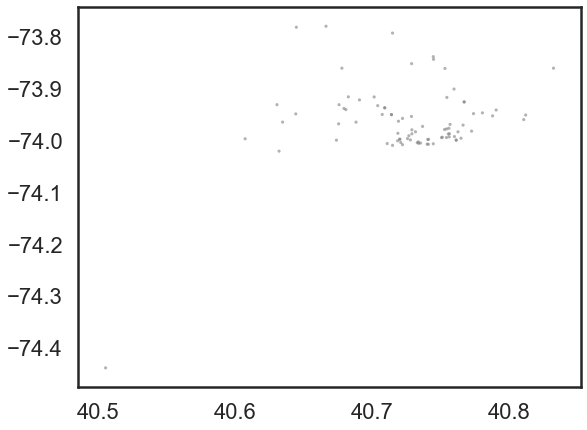

In [331]:
data9 = clus[26]
print(len(data9), "  ", i)

data = data9[["Lat","Lon"]]
test_data = data.to_numpy()
#HBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=10, gen_min_span_tree=True)
clusterer.fit(test_data)
print("Max label : ", clusterer.labels_.max())
print(np.unique(clusterer.labels_))

color_palette = sns.color_palette('deep', 8)
cluster_colors = [color_palette[x] if x >= 0 else (0.5, 0.5, 0.5) for x in clusterer.labels_] 
cluster_member_colors = [sns.desaturate(x, p) for x, p in zip(cluster_colors, clusterer.probabilities_)]
plt.scatter(*test_data.T, s=10, linewidth=0, c=cluster_member_colors, alpha=0.6)

for i in np.unique(clusterer.labels_):
    print(i, "Label count : " ,clusterer.labels_[clusterer.labels_ == i].size)

293    718
Max label :  1
[-1  0  1]


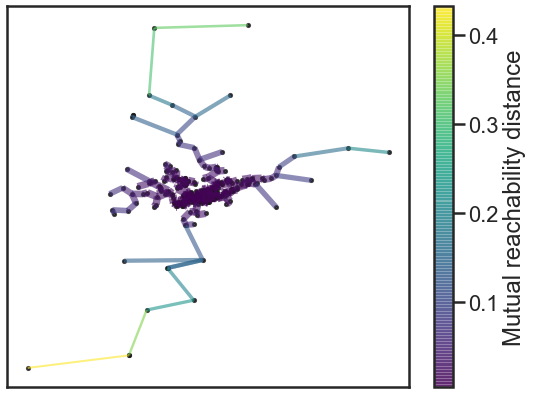

In [328]:

#HBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=11, gen_min_span_tree=True)
clusterer.fit(test_data)
print("Max label : ", clusterer.labels_.max())
print(np.unique(clusterer.labels_))

clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis', 
                                      edge_alpha=0.6, 
                                      node_size=10,
                                      edge_linewidth=2)

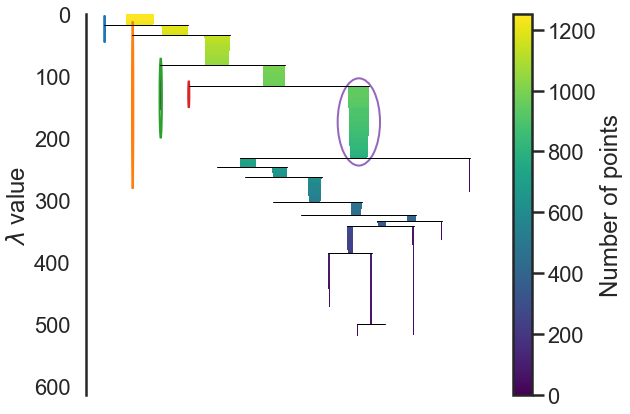

In [291]:
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())

-1 Label count :  186
0 Label count :  13
1 Label count :  30
2 Label count :  53
3 Label count :  25
4 Label count :  944


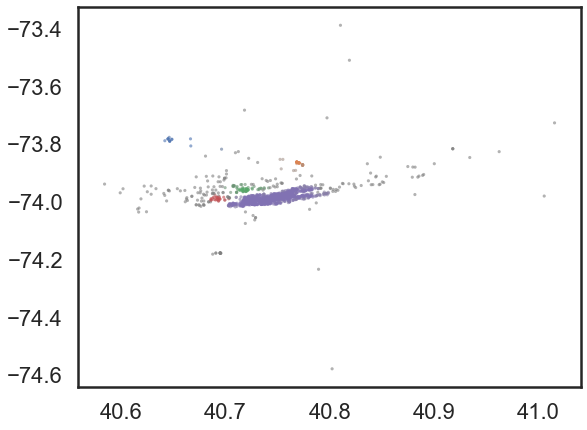

In [292]:
# palette = sns.color_palette("Set3", 12)
# cluster_colors = [sns.desaturate(palette[col], sat)
#                   if col >= 0 else (0.3,0.3,0.3) for col, sat in
#                   zip(clusterer.labels_, clusterer.probabilities_)]
# plt.scatter(test_data.T[0], test_data.T[1], c=cluster_colors, **plot_kwds)

color_palette = sns.color_palette('deep', 8)
cluster_colors = [color_palette[x] if x >= 0 else (0.5, 0.5, 0.5) for x in clusterer.labels_] 
cluster_member_colors = [sns.desaturate(x, p) for x, p in zip(cluster_colors, clusterer.probabilities_)]
plt.scatter(*test_data.T, s=10, linewidth=0, c=cluster_member_colors, alpha=0.6)

for i in np.unique(clusterer.labels_):
    print(i, "Label count : " ,clusterer.labels_[clusterer.labels_ == i].size)
    



In [281]:
# data9["label"] = clusterer.labels_
# data9["probability"] = clusterer.probabilities_
# data9
df1 = pd.DataFrame(clusterer.labels_ , columns = ["labels"])
df1["probabilities"] = clusterer.probabilities_
df1

,labels,probabilities
0,-1,0.000000
1,1,1.000000
2,1,1.000000
3,1,0.659868
4,-1,0.000000
...,...,...
869,1,1.000000
870,1,1.000000
871,1,1.000000
872,1,1.000000


In [282]:
a=0
clu = []
for i in range(len(clusterer.labels_)):
    clu.append([clusterer.labels_[i], clusterer.probabilities_[i]])
    if clusterer.probabilities_[i]>=0.9:
        a+=1
print(a)
clu

677


[[-1, 0.0],
 [1, 1.0],
 [1, 1.0],
 [1, 0.6598677577269375],
 [-1, 0.0],
 [-1, 0.0],
 [-1, 0.0],
 [-1, 0.0],
 [1, 1.0],
 [1, 1.0],
 [1, 1.0],
 [1, 1.0],
 [1, 1.0],
 [1, 1.0],
 [1, 1.0],
 [1, 1.0],
 [1, 1.0],
 [1, 1.0],
 [1, 1.0],
 [1, 1.0],
 [-1, 0.0],
 [0, 0.0426910281124368],
 [1, 1.0],
 [1, 1.0],
 [1, 1.0],
 [1, 0.6598677577271383],
 [-1, 0.0],
 [1, 1.0],
 [1, 1.0],
 [2, 0.5826229838172946],
 [1, 1.0],
 [1, 1.0],
 [1, 1.0],
 [1, 1.0],
 [-1, 0.0],
 [1, 1.0],
 [1, 1.0],
 [1, 0.6612643979061325],
 [1, 0.991710482475883],
 [-1, 0.0],
 [1, 1.0],
 [1, 1.0],
 [1, 1.0],
 [1, 1.0],
 [1, 1.0],
 [1, 0.9270082320548311],
 [1, 1.0],
 [1, 1.0],
 [1, 1.0],
 [1, 1.0],
 [1, 1.0],
 [1, 1.0],
 [1, 1.0],
 [1, 1.0],
 [1, 1.0],
 [1, 1.0],
 [1, 1.0],
 [1, 1.0],
 [1, 1.0],
 [1, 1.0],
 [1, 1.0],
 [0, 0.042717882885245965],
 [2, 1.0],
 [1, 1.0],
 [1, 1.0],
 [-1, 0.0],
 [1, 1.0],
 [-1, 0.0],
 [1, 0.6145716883240867],
 [1, 1.0],
 [2, 1.0],
 [-1, 0.0],
 [-1, 0.0],
 [1, 1.0],
 [1, 1.0],
 [1, 1.0],
 [0, 0.04225641

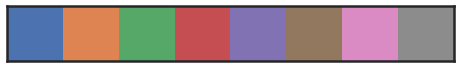

In [91]:
sns.palplot(sns.color_palette('deep', 8))

In [193]:
data = pd.read_csv("./Data/nyc_taxi_data_2014.csv")

C:\Users\Jun\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [227]:
data.tail(50)

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
14999949,VTS,2014-02-03 21:45:00,2014-02-03 21:59:00,1,3.20,-73.972500,40.758155,1,NaN,-73.976935,40.782577,CRD,13.0,0.5,0.5,4.05,0.00,18.05
14999950,VTS,2014-02-03 21:53:00,2014-02-03 21:59:00,6,1.40,-73.975567,40.776707,1,NaN,-73.957887,40.774517,CSH,7.0,0.5,0.5,0.00,0.00,8.00
14999951,VTS,2014-02-03 21:53:00,2014-02-03 22:00:00,1,2.27,-73.971973,40.753910,1,NaN,-73.951088,40.778957,CRD,9.0,0.5,0.5,1.15,0.00,11.15
14999952,VTS,2014-02-03 21:58:00,2014-02-03 22:00:00,1,0.49,-73.962255,40.763472,1,NaN,-73.966325,40.757810,CSH,4.0,0.5,0.5,0.00,0.00,5.00
14999953,VTS,2014-02-07 07:48:00,2014-02-07 07:53:00,2,0.83,-74.016897,40.709412,1,NaN,-74.011975,40.702767,UNK,5.5,0.0,0.5,1.26,0.00,7.26
14999954,VTS,2014-02-03 21:03:00,2014-02-03 21:11:00,5,2.29,-73.959672,40.758817,1,NaN,-73.948267,40.784167,CRD,9.0,0.5,0.5,2.38,0.00,12.38
14999955,VTS,2014-02-07 06:09:00,2014-02-07 06:14:00,5,1.72,-73.994372,40.750962,1,NaN,-73.974312,40.758795,CSH,7.0,0.0,0.5,0.00,0.00,7.50
14999956,VTS,2014-02-03 21:27:00,2014-02-03 21:33:00,1,2.27,-73.980017,40.754870,1,NaN,-73.997777,40.729480,CRD,8.5,0.5,0.5,2.70,0.00,12.20
14999957,VTS,2014-02-07 07:17:00,2014-02-07 07:22:00,5,0.66,-73.955420,40.777110,1,NaN,-73.951042,40.771627,CRD,5.0,0.0,0.5,1.00,0.00,6.50
14999958,VTS,2014-02-03 21:27:00,2014-02-03 21:35:00,1,2.10,-73.992680,40.720610,1,NaN,-73.977060,40.743150,CSH,8.5,0.5,0.5,0.00,0.00,9.50


In [40]:
import numpy as np
a = np.array([[1,2,3,4,5],
              [1,2,3,4,5]])
print(a[:, 4])
aaa = np.concatenate((a[:, 0:2], a[:, 1:3]), axis = 1)
aaa

[5 5]


array([[1, 2, 2, 3],
       [1, 2, 2, 3]])